<a href="https://colab.research.google.com/github/HELL-TO-HEAVEN/MyOwnNotebook/blob/master/Skin_cancer_image_classification_with_fastai_and%C2%A0Render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickly Train and Deploy an AI Computer Vision App
##Deep learning skin cancer classification with fastai and Render
### By Jeff Hale
 See this Medium article for discussion of this notebook and deploying the app on Render.
 I made changes and experimented while running this notebook. Output cells might look slightly different if you run it from  top to bottom. :)

In [0]:
Make sure we have the latest versions of key packages.

In [0]:
# update pytorch and fastai to latest versions
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U 
!pip install kaggle

Import and configure things.

In [0]:
# import the usual frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import warnings
import json
import os

from IPython.core.display import display, HTML
    
# import plotly 
import plotly
import plotly.figure_factory as ff
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls

# for color scales in plotly
import colorlover as cl 

# import deep learning libraries
import torch
import fastai
from fastai import *
from fastai.vision import *

from sklearn.metrics import auc, roc_curve, roc_auc_score

# configure things
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:,.2f}'.format  
pd.options.display.max_columns = 999

py.init_notebook_mode(connected=True)

%load_ext autoreload
%autoreload 2
%matplotlib inline

I'm going to save our data in a single directory in my Google Drive. Then I won't need to retun these cells, so they'll be commented out.

In [0]:
# mount your google drive so you can save to it. You'll need to put in a token.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# create environment variables for kaggle to authenticate with
# os.environ['KAGGLE_USERNAME'] = "xxxxxx-insert-yours"
# os.environ['KAGGLE_KEY'] = "xxxxxx-insert-yours"

In [0]:
# os.mkdir('c_skin')
# os.listdir()

In [0]:
# get the dataset from kaggle
# !kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p 'c_skin'

In [0]:
# See the files and folders. They need 'content' prepended to the path
# os.listdir('/content/c_skin')

In [0]:
# !unzip '/content/c_skin/skin-cancer-mnist-ham10000.zip'

In [0]:
# os.listdir()

In [0]:
# os.mkdir('images')
# os.listdir()

In [0]:
#!unzip 'HAM10000_images_part_2.zip' -d 'images'
#!unzip 'HAM10000_images_part_1.zip' -d 'images'


# os.mkdir('/content/gdrive/My Drive/data/images')
# !unzip 'HAM10000_images_part_2.zip' -d '/content/gdrive/My Drive/data/images'
# !unzip 'HAM10000_images_part_1.zip' -d '/content/gdrive/My Drive/data/images'

In [0]:
os.listdir()

['.config', 'gdrive', 'sample_data']

In [0]:
# print all the things

from fastai.utils.show_install import *
print(show_install())

!cat /proc/cpuinfo
!cat /proc/meminfo

!pip list



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.50.post1
fastprogress  : 0.1.20
torch         : 1.0.1.post2
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once install

In [0]:
os.getcwd()

'/content'

Let's make a dataframe.

In [0]:
df=pd.read_csv('/content/gdrive/My Drive/skin_cancer/data/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.00,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.00,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.00,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.00,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.00,male,ear


 Let's make a human-readable mapping of our classes.

In [0]:
lesion_dict = dict(               # quick online research states:
    nv='Melanocytic nevi',       # common mole
    mel='Melanoma',              # very bad
    bkl='Benign keratosis',      # benign is good
    bcc='Basal cell carcinoma',  # not so good
    akiec='Actinic keratoses',   # potential precancer
    vasc='Vascular lesions',     # could be benign or malignant
    df='Dermatofibroma',         # benign
)

In [0]:
df['diagnosis'] = df.dx.map(lesion_dict)
df.tail()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.00,male,abdomen,Actinic keratoses
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.00,male,abdomen,Actinic keratoses
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.00,male,abdomen,Actinic keratoses
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.00,male,face,Actinic keratoses
10014,HAM_0003521,ISIC_0032258,mel,histo,70.00,female,back,Melanoma


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
diagnosis       10015 non-null object
dtypes: float64(1), object(7)
memory usage: 626.0+ KB


Let's make our diagnosis a categorical datatype for numeric representation and faster processing.

In [0]:
df['diagnosis'] = df['diagnosis'].astype('category') 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             9958 non-null float64
sex             10015 non-null object
localization    10015 non-null object
diagnosis       10015 non-null category
dtypes: category(1), float64(1), object(6)
memory usage: 557.9+ KB


Let's change the order of our columns. If our image_id if first and our diagnosis is second, then our ImageDataBunch can accept the data most easily.

In [0]:
df = df[['image_id', 'diagnosis', 'lesion_id', 'dx', 'dx_type', 'age', 'sex', 'localization']]
df.head()

,image_id,diagnosis,lesion_id,dx,dx_type,age,sex,localization
0,ISIC_0027419,Benign keratosis,HAM_0000118,bkl,histo,80.00,male,scalp
1,ISIC_0025030,Benign keratosis,HAM_0000118,bkl,histo,80.00,male,scalp
2,ISIC_0026769,Benign keratosis,HAM_0002730,bkl,histo,80.00,male,scalp
3,ISIC_0025661,Benign keratosis,HAM_0002730,bkl,histo,80.00,male,scalp
4,ISIC_0031633,Benign keratosis,HAM_0001466,bkl,histo,75.00,male,ear


In [0]:
df = df.rename(columns={"diagnosis": "classes"})
df.head()

,image_id,classes,lesion_id,dx,dx_type,age,sex,localization
0,ISIC_0027419,Benign keratosis,HAM_0000118,bkl,histo,80.00,male,scalp
1,ISIC_0025030,Benign keratosis,HAM_0000118,bkl,histo,80.00,male,scalp
2,ISIC_0026769,Benign keratosis,HAM_0002730,bkl,histo,80.00,male,scalp
3,ISIC_0025661,Benign keratosis,HAM_0002730,bkl,histo,80.00,male,scalp
4,ISIC_0031633,Benign keratosis,HAM_0001466,bkl,histo,75.00,male,ear


Let's make a subsample of our data for faster training. We'll take a random sample of 1000 rows.

In [0]:
df_1000 = df.sample(1000)
df_1000.head()

,image_id,classes,lesion_id,dx,dx_type,age,sex,localization
4459,ISIC_0024427,Melanocytic nevi,HAM_0003988,nv,follow_up,65.00,male,abdomen
3907,ISIC_0032411,Melanocytic nevi,HAM_0000034,nv,follow_up,50.00,female,upper extremity
9246,ISIC_0029498,Melanocytic nevi,HAM_0001356,nv,consensus,60.00,female,chest
7633,ISIC_0032787,Melanocytic nevi,HAM_0001935,nv,histo,50.00,male,chest
8799,ISIC_0025088,Melanocytic nevi,HAM_0002423,nv,histo,30.00,female,abdomen


In [0]:
df_1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 4459 to 4122
Data columns (total 8 columns):
image_id        2000 non-null object
classes         2000 non-null category
lesion_id       2000 non-null object
dx              2000 non-null object
dx_type         2000 non-null object
age             1989 non-null float64
sex             2000 non-null object
localization    2000 non-null object
dtypes: category(1), float64(1), object(6)
memory usage: 127.3+ KB


Now let's read in our data. First we'll define the path to our images.

In [0]:
path = '/content/gdrive/My Drive/skin_cancer/data/images'

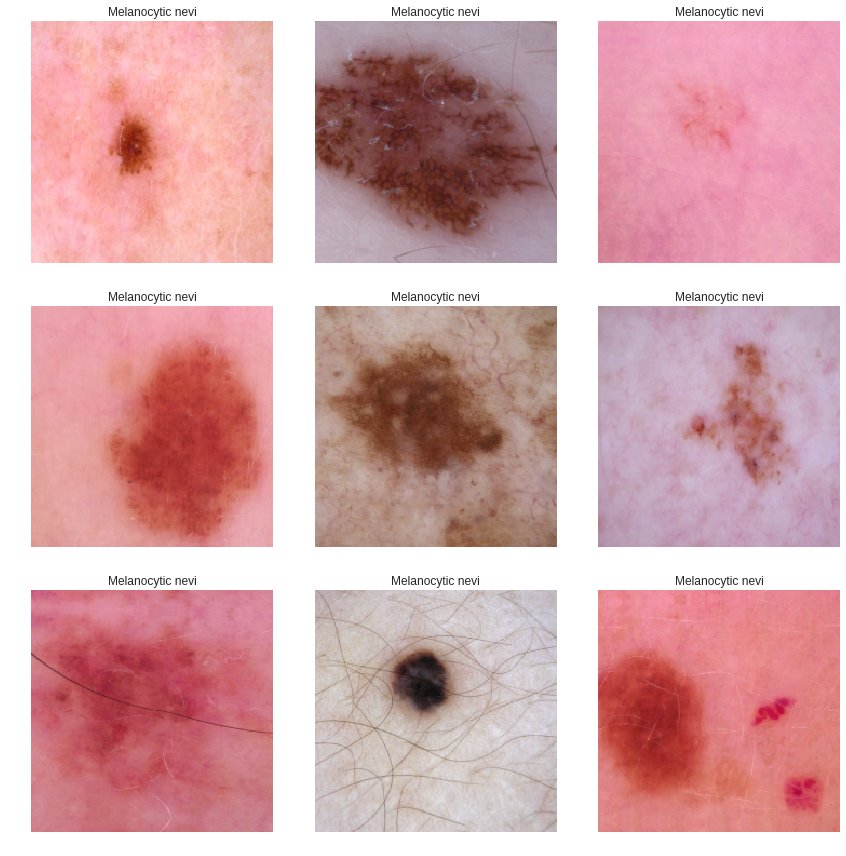

In [0]:
data = ImageDataBunch.from_df(
    path=path,       # path to images folder
    df=df,           # dataframe name
    suffix='.jpg',   # image file suffix
    ds_tfms=get_transforms(),   # data augmentation
    size=224,        # image size
    bs=64,           # 64 is default, can adjust
)

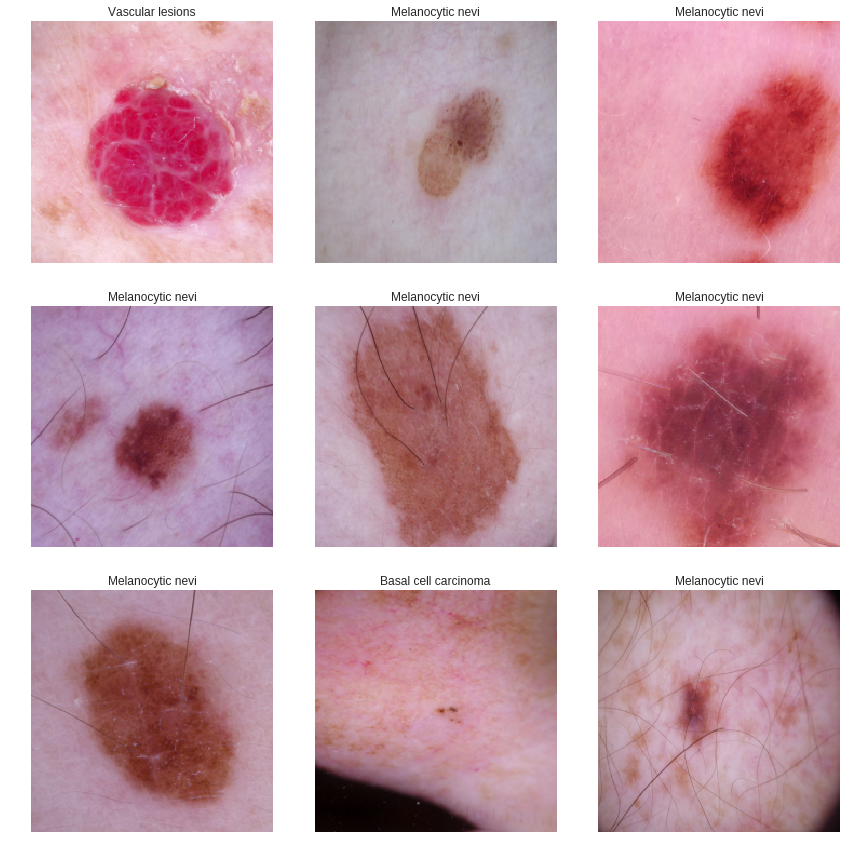

In [0]:
data.show_batch(rows=3)

It works!

Let's normalize our data and create a learner object with resnet34 for transfer learning.

In [0]:
data.normalize(imagenet_stats)  

ImageDataBunch;

Train: LabelList (8012 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis,Benign keratosis
Path: /content/gdrive/My Drive/skin_cancer/data/images;

Valid: LabelList (2003 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Melanocytic nevi,Basal cell carcinoma
Path: /content/gdrive/My Drive/skin_cancer/data/images;

Test: None

Let's create a learner object.

If path is provided, all the model files created will be saved in path/model_dir

In [0]:
learner = cnn_learner(
    data, 
    models.resnet50, 
    metrics=[error_rate, Recall(), Precision(), FBeta(), MatthewsCorreff()], 
    path='/content/gdrive/My Drive/skin_cancer/models'
)

Let's make sure we have an appropriate loss function.

In [0]:
learner.loss_func

That's what we want. 

Let's see which learning rate we should choose.

In [0]:
# learner.lr_find()
# learner.recorder.plot()

Ok. Where is that just starting to get steep. 1e-03, I'd say. The default is 3e-03. Close enough. The learning rate finder becomes more important when we unfreeze the model and keep training.

Let's train for four epochs.

In [0]:
learner.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,1.185114,0.694238,0.224663,0.480517,0.575452,0.482497,0.536072,05:54
1,0.724293,0.559733,0.207189,0.544428,0.714764,0.571675,0.578841,05:45
2,0.586628,0.507487,0.184723,0.588490,0.684232,0.605433,0.612400,05:47
3,0.512698,0.466707,0.159261,0.633263,0.765623,0.655943,0.671511,05:47
4,0.463094,0.453301,0.155766,0.644379,0.749327,0.662949,0.678946,05:49



That takes a little while. We should make a subset of the data to play with so we can iterate more quickly.  

Later, we should also look at doing mixed precision training and varying our batch sizes.

In [0]:
learner.save('stage-1-rn50-bs64-fp32-4epochs-10000imgs')

In [0]:
learner.lr_find()
learner.recorder.plot()

Let's unfreeze and do another four epochs of training. For learning rate annealing, we'll use what we find for the lr_find() and end at 10x smaller than our previous learning rate. 

In [0]:
learner.unfreeze()
learner.fit_one_cycle(4, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,0.445354,0.421881,0.155267,0.667797,0.765914,0.682258,0.680582,06:02
1,0.420665,0.380162,0.134299,0.737786,0.798559,0.749189,0.727012,06:02
2,0.296856,0.362370,0.132801,0.728010,0.815504,0.743974,0.729974,06:05
3,0.232770,0.346595,0.126810,0.747168,0.827729,0.762001,0.740917,06:05


Let's save the model.

In [0]:
learner.save('stage-2-rn50-bs64-fp32-4epochs-10000imgs')

Let's load the model for more training.

In [0]:
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,0.267088,0.376221,0.133799,0.725430,0.812809,0.740453,0.725850,06:03
1,0.205428,0.343281,0.124813,0.730837,0.814480,0.746163,0.746578,06:04


In [0]:
learner.save('stage-3-rn50-bs64-fp32-10epochs-10000imgs')

In [0]:
learner.unfreeze()
learner.fit_one_cycle(2, slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,recall,precision,f_beta,matthews_correff,time
0,0.208109,0.371761,0.129306,0.739037,0.804176,0.748842,0.740195,06:03
1,0.153128,0.329834,0.107339,0.766745,0.827014,0.778086,0.784792,06:05


In [0]:
learner.save('stage-4-rn50-bs64-fp32-12epochs-10000imgs')

In [0]:
# learner = load_learner('/content/gdrive/My Drive/skin_cancer/models')

In [0]:
learner.export('export2')

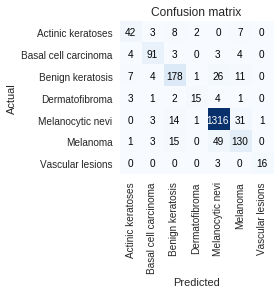

In [0]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
interp.plot_confusion_matrix()

Let's see what our model looks like.

In [0]:
learner.model

Let's export our learner for inference.

If we did mixed-precision training above we need to switch back to fp32 now.

In [0]:
# learner.to_fp32()

Let's look at the confusion matrix.


In [0]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

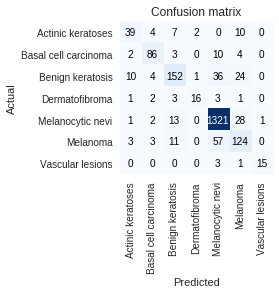

In [0]:
interp.plot_confusion_matrix()

Half the Melanoma cases were misclassified. That's not good! I guess that's why melanoma can be tricky to diagnose.

In [0]:
interp.most_confused()

[('Melanoma', 'Melanocytic nevi', 57),
 ('Benign keratosis', 'Melanocytic nevi', 36),
 ('Melanocytic nevi', 'Melanoma', 28),
 ('Benign keratosis', 'Melanoma', 24),
 ('Melanocytic nevi', 'Benign keratosis', 13),
 ('Melanoma', 'Benign keratosis', 11),
 ('Actinic keratoses', 'Melanoma', 10),
 ('Basal cell carcinoma', 'Melanocytic nevi', 10),
 ('Benign keratosis', 'Actinic keratoses', 10),
 ('Actinic keratoses', 'Benign keratosis', 7),
 ('Actinic keratoses', 'Basal cell carcinoma', 4),
 ('Basal cell carcinoma', 'Melanoma', 4),
 ('Benign keratosis', 'Basal cell carcinoma', 4),
 ('Basal cell carcinoma', 'Benign keratosis', 3),
 ('Dermatofibroma', 'Benign keratosis', 3),
 ('Dermatofibroma', 'Melanocytic nevi', 3),
 ('Melanoma', 'Actinic keratoses', 3),
 ('Melanoma', 'Basal cell carcinoma', 3),
 ('Vascular lesions', 'Melanocytic nevi', 3),
 ('Actinic keratoses', 'Dermatofibroma', 2),
 ('Basal cell carcinoma', 'Actinic keratoses', 2),
 ('Dermatofibroma', 'Basal cell carcinoma', 2),
 ('Melanocyt

Looking pretty good. Let's train some more and see if we can keep improving.

In [0]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)
interp.plot_confusion_matrix()

In [0]:
interp.plot_top_losses(9, figsize=(10,10))

In [0]:
learner.export('export')

Let's look at the ROC AUC score and curve.

Happy building!